In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras import optimizers
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input
from keras.models import Model

In [ ]:
#Add the google drive.
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip the Training data file.
!unzip /content/drive/MyDrive/Colab/257_termProj/Data.zip -d mydata

Streaming output truncated to the last 5000 lines.
  inflating: mydata/imgs/train/c7/img_56636.jpg  
  inflating: mydata/imgs/train/c7/img_56661.jpg  
  inflating: mydata/imgs/train/c7/img_56699.jpg  
  inflating: mydata/imgs/train/c7/img_56717.jpg  
  inflating: mydata/imgs/train/c7/img_56724.jpg  
  inflating: mydata/imgs/train/c7/img_56768.jpg  
  inflating: mydata/imgs/train/c7/img_56779.jpg  
  inflating: mydata/imgs/train/c7/img_56849.jpg  
  inflating: mydata/imgs/train/c7/img_56899.jpg  
  inflating: mydata/imgs/train/c7/img_56938.jpg  
  inflating: mydata/imgs/train/c7/img_5706.jpg  
  inflating: mydata/imgs/train/c7/img_57076.jpg  
  inflating: mydata/imgs/train/c7/img_57122.jpg  
  inflating: mydata/imgs/train/c7/img_57137.jpg  
  inflating: mydata/imgs/train/c7/img_5715.jpg  
  inflating: mydata/imgs/train/c7/img_57278.jpg  
  inflating: mydata/imgs/train/c7/img_57321.jpg  
  inflating: mydata/imgs/train/c7/img_57345.jpg  
  inflating: mydata/imgs/train/c7/img_57355.jpg  
 

In [ ]:
#Loading the driver list
driver_info = pd.read_csv('/content/mydata/driver_imgs_list.csv',na_values='na')
print(driver_info.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
#Reading training data and assigning labels to them based on the folder names.
train_image = []
image_label = []

for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/mydata/imgs/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/content/mydata/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_info[driver_info['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
#Shuffling the train data.
import random
random.shuffle(train_image)

In [ ]:
#Keeping aside few drivers for validation purpose to take care of overfitting issues.
driver_for_validatation = ['p050', 'p015', 'p022', 'p056']

In [ ]:
#Splitting the train and test Data based on drivers.
training_data = []
training_labels = []
tesing_data = []
testing_labels  = []
true_test_values =[]

for features,labels,drivers in train_image:
    if drivers in driver_for_validatation:
        tesing_data.append(features)
        testing_labels.append(labels)
        true_test_values.append(labels)
    
    else:
        training_data.append(features)
        training_labels.append(labels)
    
print ('Total number of data in training data set with : ',len(training_data),'corresponding no. of labels as ', len(training_labels))
print ('Total number of data in validation data set with : ',len(tesing_data),'corresponding no. of labels as ', len(tesing_data))

Total number of data in training data set with :  18732 corresponding no. of labels as  18732
Total number of data in validation data set with :  3692 corresponding no. of labels as  3692


In [ ]:
#Converting images to nparray and categorically encoding the Y data

X_train = np.array(training_data).reshape(-1,224,224,3)
X_test = np.array(tesing_data).reshape(-1,224,224,3)
y_train = to_categorical(training_labels)
y_test = to_categorical(testing_labels)

#Checking the training data size.
print (X_train.shape)

(18732, 224, 224, 3)


Creating the Base Model

In [ ]:
#Defining the input for VGG16 model
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')
#The VGG16 base model
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Adding Classifier to the base model

In [ ]:
#Adding Classifier layer for the VGG convolution model with 10 output neural 1 for each classes.

#output 
output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Adding Flatten layer
x = Flatten(name='flatten')(output_vgg16_conv)

#Adding a dense layer with 10 neurons.
x = Dense(10, activation='softmax', name='predictions')(x)

#Creating the VGG model
model_vgg16 = Model(vgg16_input, outputs = x)
model_vgg16.summary()

# Compile VGG16 model
sgd = optimizers.SGD(lr = 0.001)
model_vgg16.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


Training the Model

In [ ]:
#Setting the callback params
checkpointer = ModelCheckpoint('vgg_weights_final.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#Augumenting the data.
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

#Training the modeling
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_history = model_vgg16.fit(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
293/292 [==============================] - ETA: 0s - loss: 2.4125 - accuracy: 0.1036
Epoch 00001: val_loss improved from inf to 2.30369, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 214s 730ms/step - loss: 2.4125 - accuracy: 0.1036 - val_loss: 2.3037 - val_accuracy: 0.0867
Epoch 2/25
293/292 [==============================] - ETA: 0s - loss: 2.2806 - accuracy: 0.1313
Epoch 00002: val_loss improved from 2.30369 to 2.28692, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 215s 733ms/step - loss: 2.2806 - accuracy: 0.1313 - val_loss: 2.2869 - val_accuracy: 0.1170
Epoch 3/25
293/292 [==============================] - ETA: 0s - loss: 2.2480 - accuracy: 0.1552
Epoch 00003: val_loss improved from 2.28692 to 2.19992, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 212s 724ms/step - loss: 2.2480 - accuracy: 0.1552 - val_loss: 2.1999 - val_accuracy: 0.1498

In [ ]:
def plot_train_history(history):
    #Plotting accuracy over the Epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #Plotting loss over the Epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

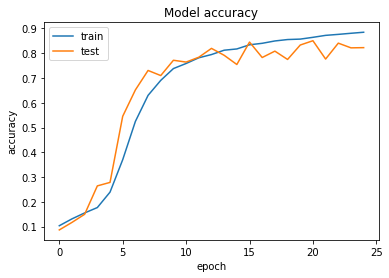

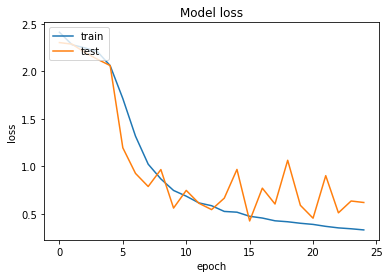

In [ ]:
#Plotting the model accuracy and loss graph. 
plot_train_history(vgg16_history)

Generating labels for the non-labeled test data

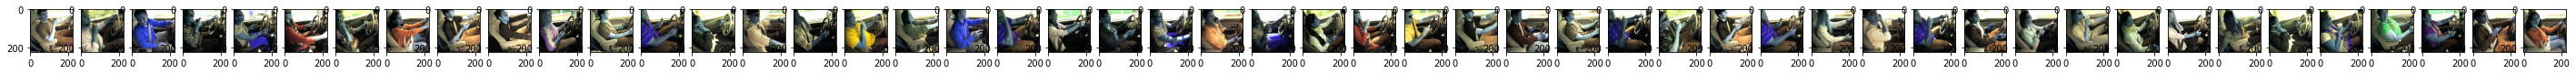

In [ ]:
#Reading 50 images from the unlabelled test data folder for image validation.
test_image = []
i = 0
fig, ax = plt.subplots(1, 50, figsize = (50,50 ))
img_rows = 224
img_cols = 224
color_type = 3
files = os.listdir('/content/mydata/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=50)
for i in range(50):
    img = cv2.imread('/content/mydata/imgs/test/'+files[nums[i]])
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img)
    plt.show

In [ ]:
#Testing the images
test = []
for img in test_image:
    test.append(img)
    
model_vgg16.load_weights('/content/vgg_weights_final.hdf5')
test = np.array(test).reshape(-1,224,224,3)
prediction = model_vgg16.predict(test)

In [ ]:
#Adding discription to the classes.
classes = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

In [ ]:
#plotting the labels for all the unlabeled test data.
fig, ax = plt.subplots( 50, 1, figsize = (200,200))
i = 0
for i in range(50):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(classes[predicted_class])
    plt.show

Output hidden; open in https://colab.research.google.com to view.

Getting the classification report for the validation data

In [ ]:
#Validation data  check
X_test.shape

In [ ]:
#Predicting the labels for validation data 
pred_class = []
prediction = model_vgg16.predict(X_test)
for i in range(len(prediction)):
      pred_class.append(np.where(prediction[i] == np.amax(prediction[i]))[0][0])

In [ ]:
#Checking the Accuracy and 
print('Images Predicted until now:',len(pred_class))
print('The accuracy of this model over validation set is:',accuracy_score(true_test_values,pred_class))
confusion_matrix(true_test_values,pred_class)

Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8223185265438786


array([[225,   1,   0,   0,   1,  78,   0,   0,  39,  68],
       [  1, 316,   1,   1,   0,   0,   6,   0,   3,  11],
       [  0,   0, 312,   0,   0,   0,   0,   0,  36,   0],
       [  4,   0,   0, 391,   3,   0,   0,   0,   0,   1],
       [  3,   0,   0,   0, 266,  37,   0,   0,  87,   3],
       [  0,   0,   0,   0,   0, 401,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0, 310,   0,  82,   0],
       [  0,   0,   0,   0,   0,   0,   0, 330,   1,   3],
       [  1,   0,  23,   0,   0,   4,  17,  51, 231,   5],
       [ 39,   0,   0,   0,   0,  28,   0,   1,  15, 254]])

Testing the labeled test data

In [ ]:
#Testing the test data 
!unzip /content/drive/MyDrive/Colab/257_termProj/Test_Data.zip -d myTestData

Archive:  /content/drive/MyDrive/Colab/257_termProj/Test_Data.zip
replace myTestData/Test_Data/c9/img_507.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: myTestData/Test_Data/c9/img_507.jpg  
  inflating: myTestData/Test_Data/c2/img_49.jpg  
  inflating: myTestData/Test_Data/c9/img_102137.jpg  
  inflating: myTestData/Test_Data/c9/img_102078.jpg  
  inflating: myTestData/Test_Data/c8/img_630.jpg  
  inflating: myTestData/Test_Data/c8/img_549.jpg  
  inflating: myTestData/Test_Data/c8/img_43.jpg  
  inflating: myTestData/Test_Data/c9/img_102066.jpg  
  inflating: myTestData/Test_Data/c2/img_33.jpg  
  inflating: myTestData/Test_Data/c9/img_44.jpg  
  inflating: myTestData/Test_Data/c2/img_25.jpg  
  inflating: myTestData/Test_Data/c2/img_86.jpg  
  inflating: myTestData/Test_Data/c9/img_36.jpg  
  inflating: myTestData/Test_Data/c9/img_622.jpg  
  inflating: myTestData/Test_Data/c9/img_102104.jpg  
  inflating: myTestData/Test_Data/c2/img_87.jpg  
  inflating: myTestData/Test_

In [ ]:
#Extracting labels of all the test images,based on the folder names.
test_image = []
for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/myTestData/Test_Data/c"+str(i))
    #print(imgs)
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/content/myTestData/Test_Data/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        test_image.append([img,label])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
#Labeling the test data
X_test_new = []
y_test_new = []

for features,labels in test_image:
        X_test_new.append(features)
        y_test_new.append(labels)
    
print ('Total number of data in training data set with : ',len(X_test_new),', corresponding no. of labels as ', len(y_test_new))


Total number of data in training data set with :  295 , corresponding no. of labels as  295


In [ ]:
#Converting the data test data to numpy array and labels of test data into categorical encoding.
X_newtest = np.array(X_test_new).reshape(-1,224,224,3)
Y_newtest = to_categorical(y_test_new)

In [ ]:
#Predicting the classes for the test data.
pred_class = []
model_prediction = model_vgg16.predict(X_newtest)
for i in range(len(model_prediction)):
      pred_class.append(np.where(model_prediction[i] == np.amax(model_prediction[i]))[0][0])

In [ ]:
#Printing the accuracy , Classification report and Confusion Matrix for the test data 
print('Images Predicted until now:',len(model_prediction))
print('The accuracy of this model over test set is:',accuracy_score(y_test_new,pred_class))
print('\n')
print('Classification Report')
print(classification_report(y_test_new,pred_class))
print('\n')
print('confusion_matrix')
confusion_matrix(y_test_new,pred_class)

Images Predicted until now: 295
The accuracy of this model over test set is: 0.823728813559322


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.39      0.57        38
           1       1.00      0.81      0.89        36
           2       0.94      0.81      0.87        37
           3       1.00      0.96      0.98        27
           4       1.00      0.89      0.94        35
           5       0.74      0.97      0.84        32
           6       0.88      0.90      0.89        31
           7       0.95      1.00      0.97        35
           8       0.21      0.83      0.33         6
           9       0.48      0.72      0.58        18

    accuracy                           0.82       295
   macro avg       0.82      0.83      0.79       295
weighted avg       0.90      0.82      0.83       295



confusion_matrix


array([[15,  0,  0,  0,  0,  9,  1,  0,  4,  9],
       [ 0, 29,  0,  0,  0,  0,  3,  0,  2,  2],
       [ 0,  0, 30,  0,  0,  0,  0,  0,  6,  1],
       [ 0,  0,  0, 26,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  1,  0, 31,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0, 31,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 28,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 35,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  5,  0],
       [ 0,  0,  1,  0,  0,  2,  0,  1,  1, 13]])